<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телескоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [91]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/content/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [92]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [93]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [94]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [95]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [96]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

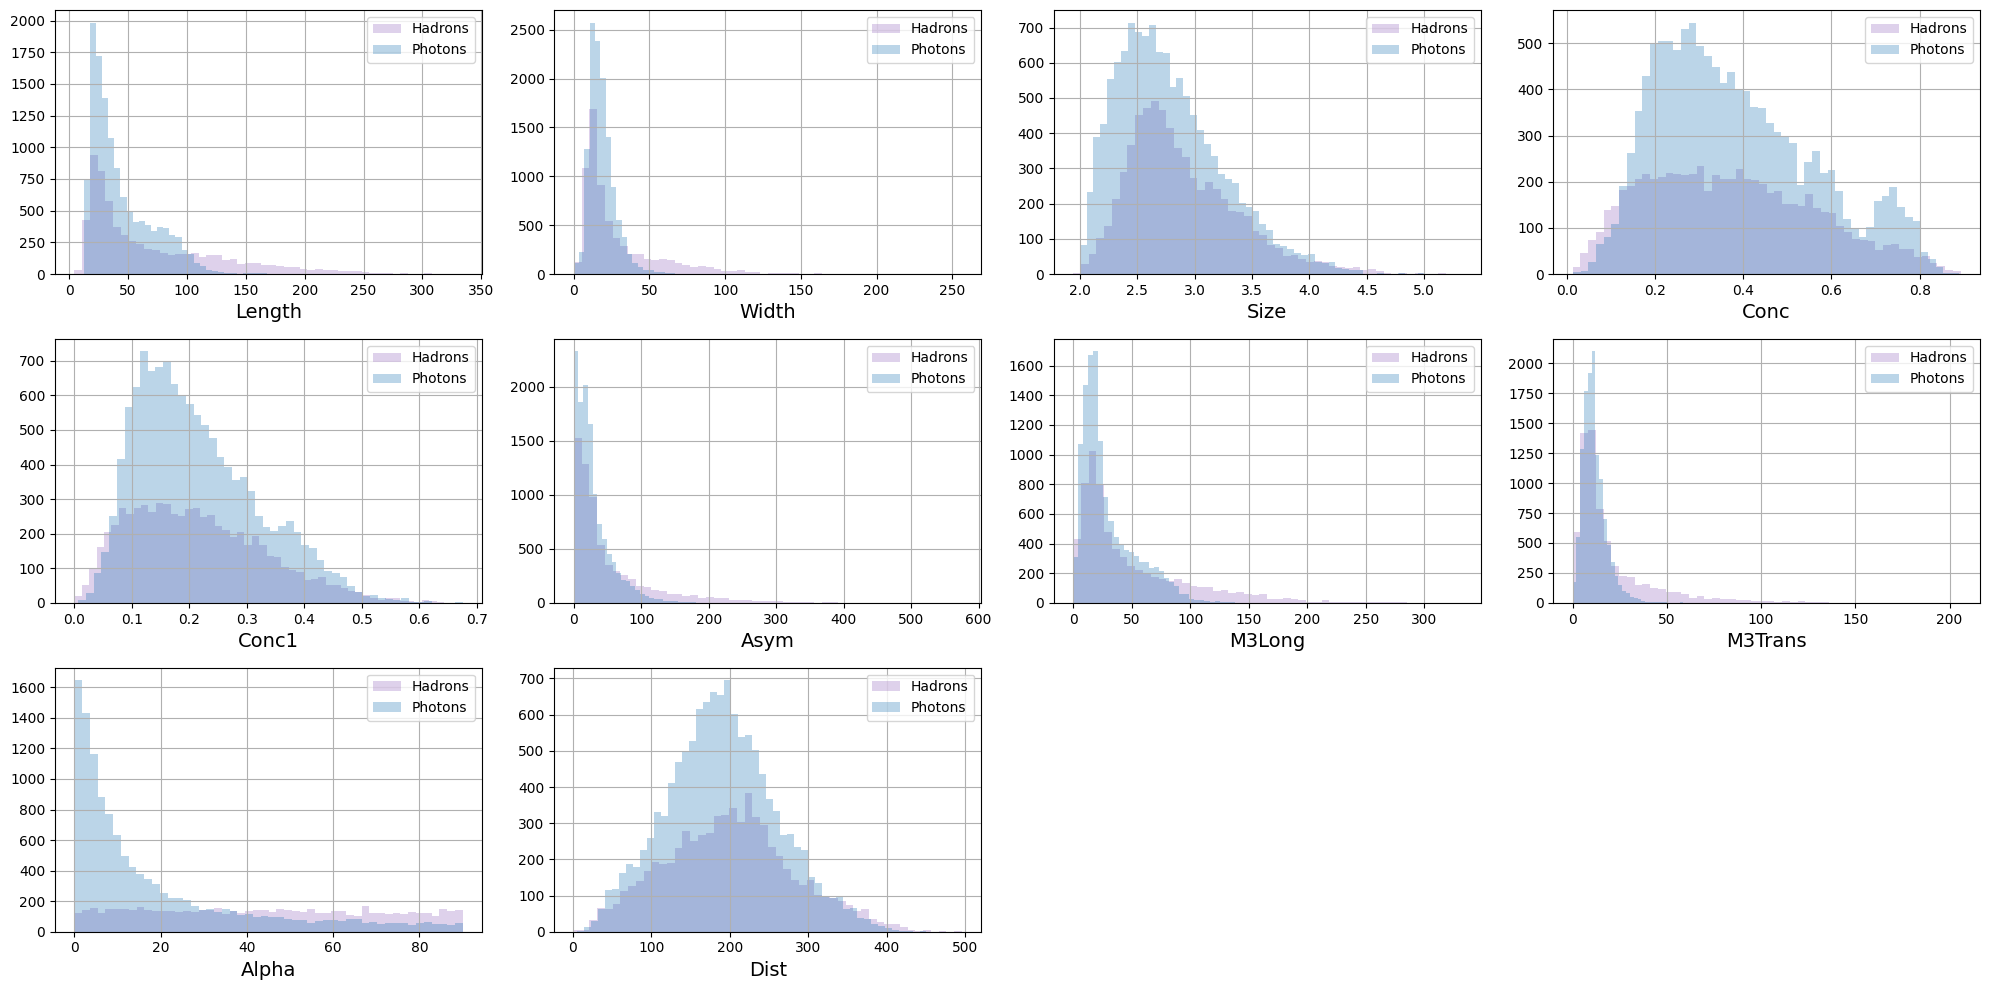

In [97]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [98]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение целевой переменной внутри train и test выборки. Совпадает ли оно? Есть ли идеи почему так?

__Подсказка__: посмотрите на клеточку с разделением данных

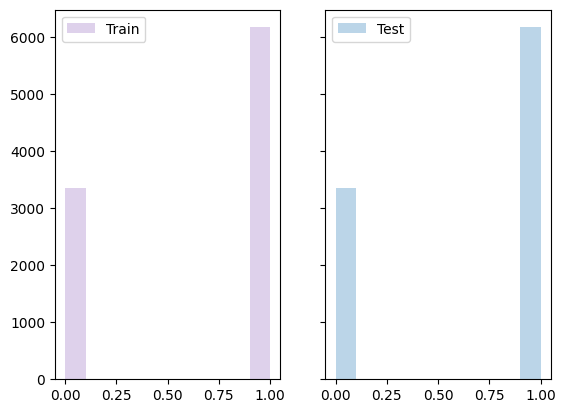

In [99]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(y_train, alpha=0.3, label='Train', color="C4")
ax2.hist(y_test, alpha=0.3, label='Test', color="C0")
ax1.legend(loc="best")
ax2.legend(loc="best")

Распределения классов совпадают, так как в функции train_test_split указан параметр stratify=y, который позволяет сохранить одинаковые распределения целевой переменной в обучающей и тестовой выборках.

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [100]:
from sklearn.preprocessing import QuantileTransformer

In [101]:
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
### YOUR CODE IS HERE ######
X_train_transformed = qt.fit_transform(X_train)
X_test_transformed = qt.transform(X_test)
### THE END OF YOUR CODE ###

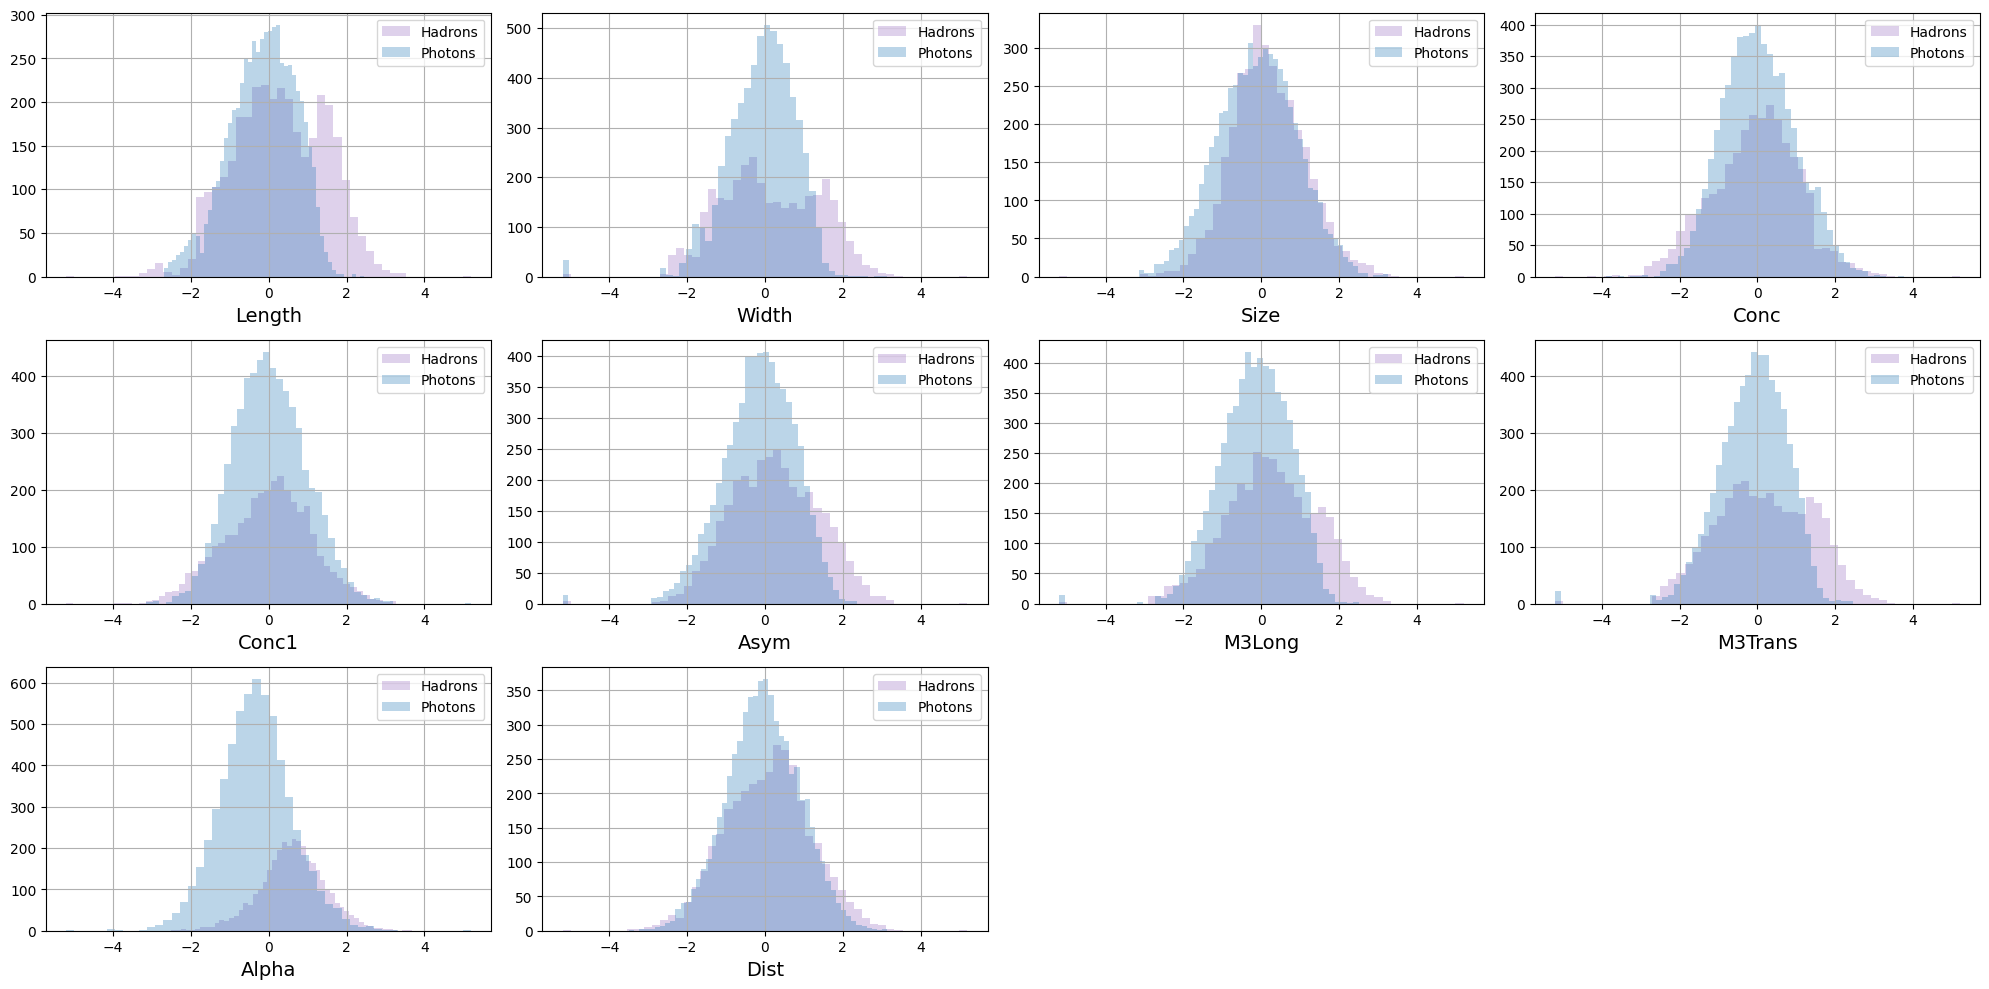

In [102]:
plot_hists(
    X_train_transformed[y_train[:, 0] == 0],
    X_train_transformed[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

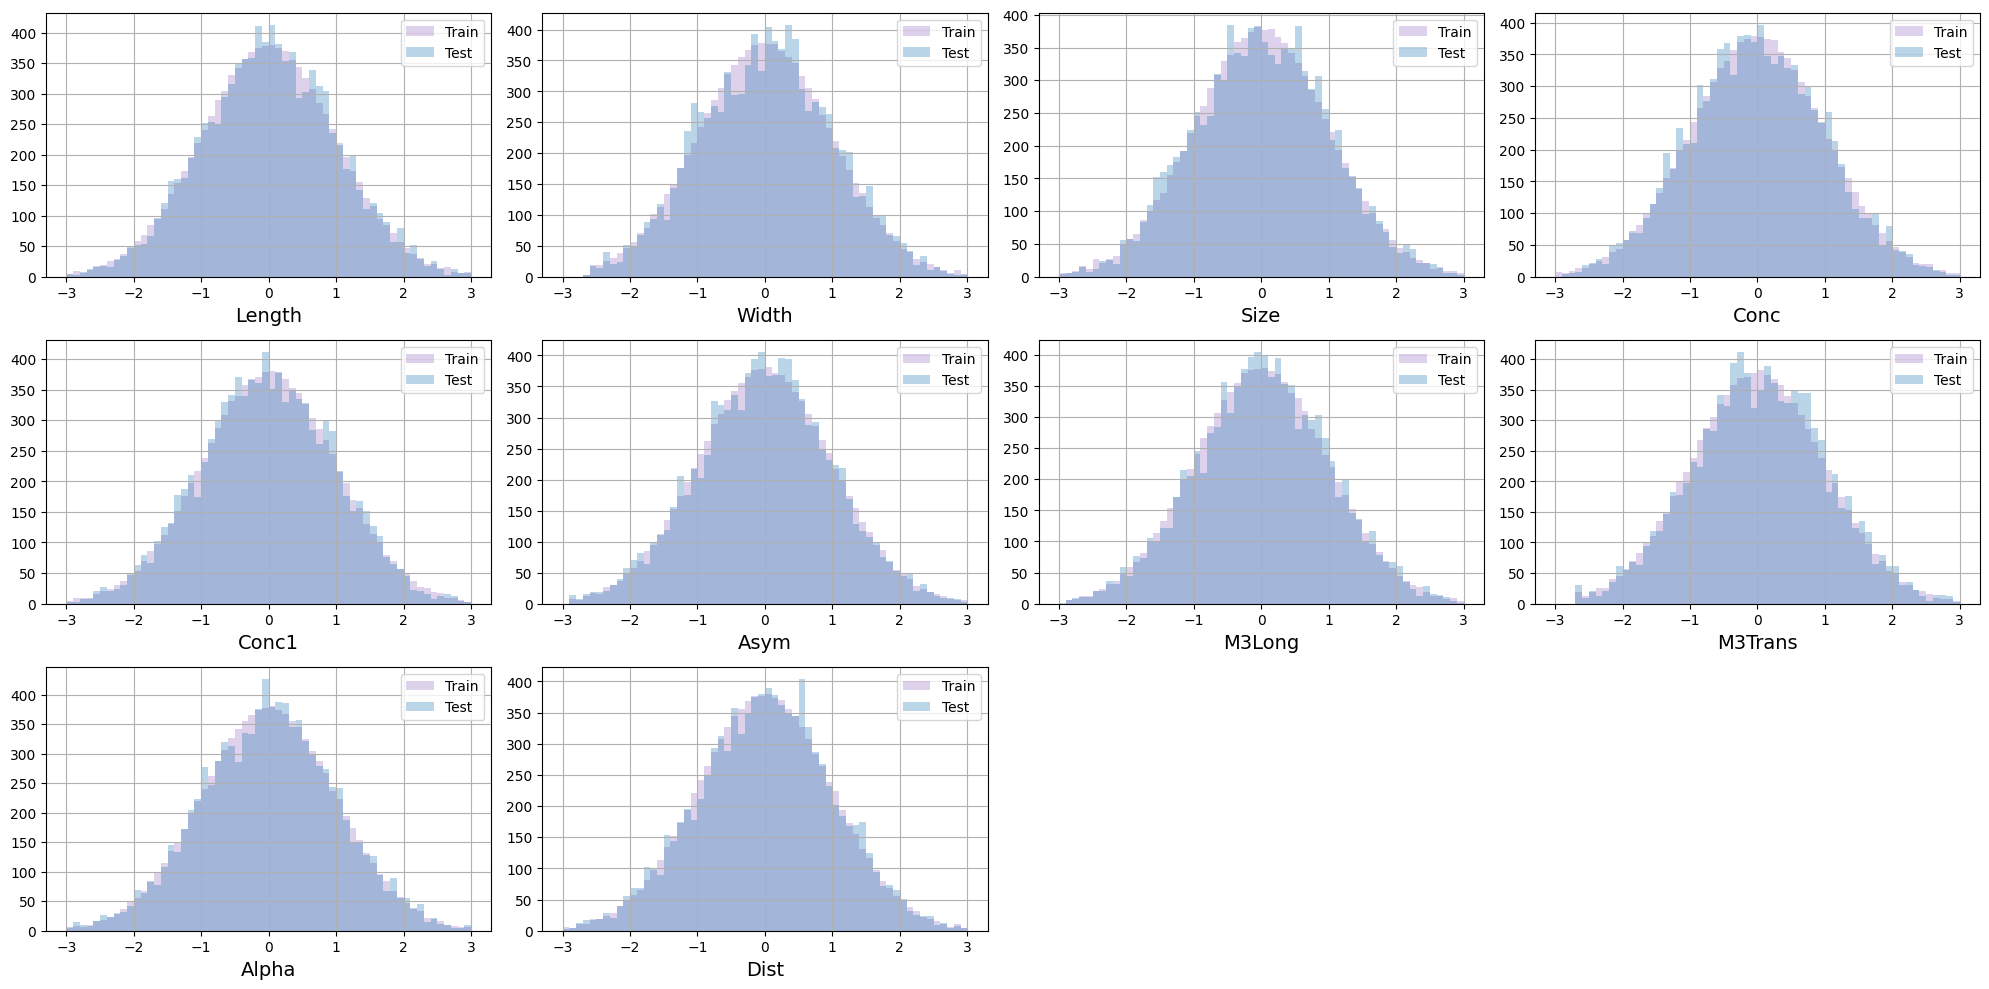

In [103]:
plot_hists(X_train_transformed, X_test_transformed, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + \frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [106]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        self.linear= nn.Linear(100, n_outputs)

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        temp = self.block(zy)
        temp = self.linear(temp)
        return temp

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [107]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    batch_size = y.shape[0]
    z = torch.normal(0, 1, (batch_size, latent_dim), device=DEVICE)
    y_tensor = torch.tensor(y, dtype=torch.float, device=DEVICE)

    with torch.no_grad():
        X_fake = generator(z, y_tensor)
    ### THE END OF YOUR CODE ###
    return X_fake.cpu().numpy()  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [108]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.block = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        temp = self.block(xy)
        return temp

Не думаю, что здесь должна быть функция активации, так как в качестве функции потерь мы используем не вероятностные методы, а другую функцию потерь, в которой используются скалярные значения.

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [110]:
def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######
    X = np.vstack((X_real, X_fake))
    y = np.hstack((y_real.T, y_fake.T)).T.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    lin_reg_score = accuracy_score(y_test, log_reg.predict(X_test))

    boosting = GradientBoostingClassifier()
    boosting.fit(X_train, y_train)
    boosting_score = accuracy_score(y_test, boosting.predict(X_test))
    ### THE END OF YOUR CODE ###
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

Нам бы хотелось accuracy 0,5, чтобы наш дискриминатор не мог нормально отличить оригинальный объект от сгенерированного. Чем выше accuracy, тем хуже наш генератор.

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [111]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                self.opt_disc.zero_grad()
                z = torch.normal(0, 1, (real_batch.size(0), self.latent_dim), device=DEVICE)
                fake_batch = self.generator(z, cond_batch)

                loss_of_disc = -torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(fake_batch, cond_batch))
                loss_of_disc.backward()
                self.opt_disc.step()

                for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

                if i % self.n_critic == 0:
                    self.opt_gen.zero_grad()
                    z = torch.normal(0, 1, (real_batch.size(0), self.latent_dim), device=DEVICE)
                    fake_batch = self.generator(z, cond_batch)

                    loss_of_gen = -torch.mean(self.discriminator(fake_batch, cond_batch))
                    loss_of_gen.backward()
                    self.opt_gen.step()
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim), device=DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            idx_real = np.random.choice(len(X_real), 1000, replace=False)
            idx_fake = np.random.choice(len(X_fake), 1000, replace=False)
            other_agent_score(X_real[idx_real].cpu().detach().numpy(), y_cond[idx_real].cpu().detach().numpy(),
                              X_fake[idx_fake].cpu().detach().numpy(), y_cond[idx_fake].cpu().detach().numpy())
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [112]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train_transformed, y_train)

Linear regression score: 0.75
Boosting score: 0.77
Linear regression score: 0.752
Boosting score: 0.736
Linear regression score: 0.758
Boosting score: 0.754
Linear regression score: 0.74
Boosting score: 0.738
Linear regression score: 0.75
Boosting score: 0.76
Linear regression score: 0.752
Boosting score: 0.74
Linear regression score: 0.77
Boosting score: 0.792
Linear regression score: 0.77
Boosting score: 0.78
Linear regression score: 0.784
Boosting score: 0.782
Linear regression score: 0.8
Boosting score: 0.81
Linear regression score: 0.79
Boosting score: 0.774
Linear regression score: 0.794
Boosting score: 0.808
Linear regression score: 0.82
Boosting score: 0.824
Linear regression score: 0.796
Boosting score: 0.8
Linear regression score: 0.79
Boosting score: 0.804
Linear regression score: 0.808
Boosting score: 0.796
Linear regression score: 0.808
Boosting score: 0.812
Linear regression score: 0.818
Boosting score: 0.816
Linear regression score: 0.818
Boosting score: 0.816
Linear reg

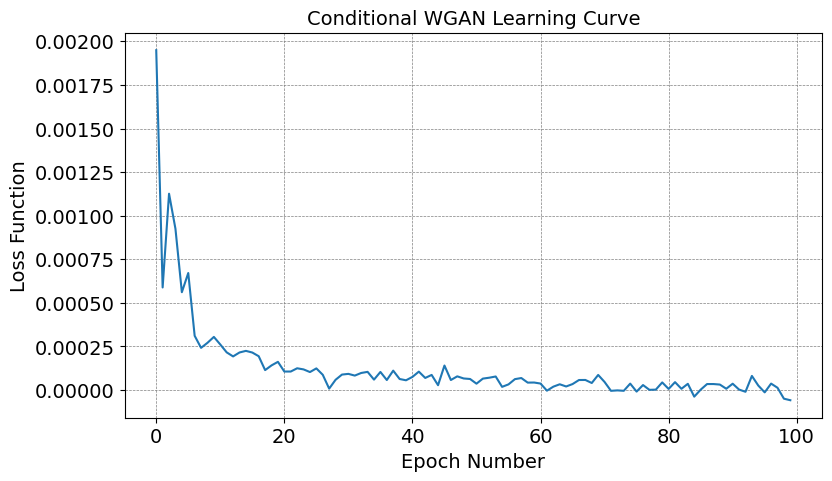

In [113]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

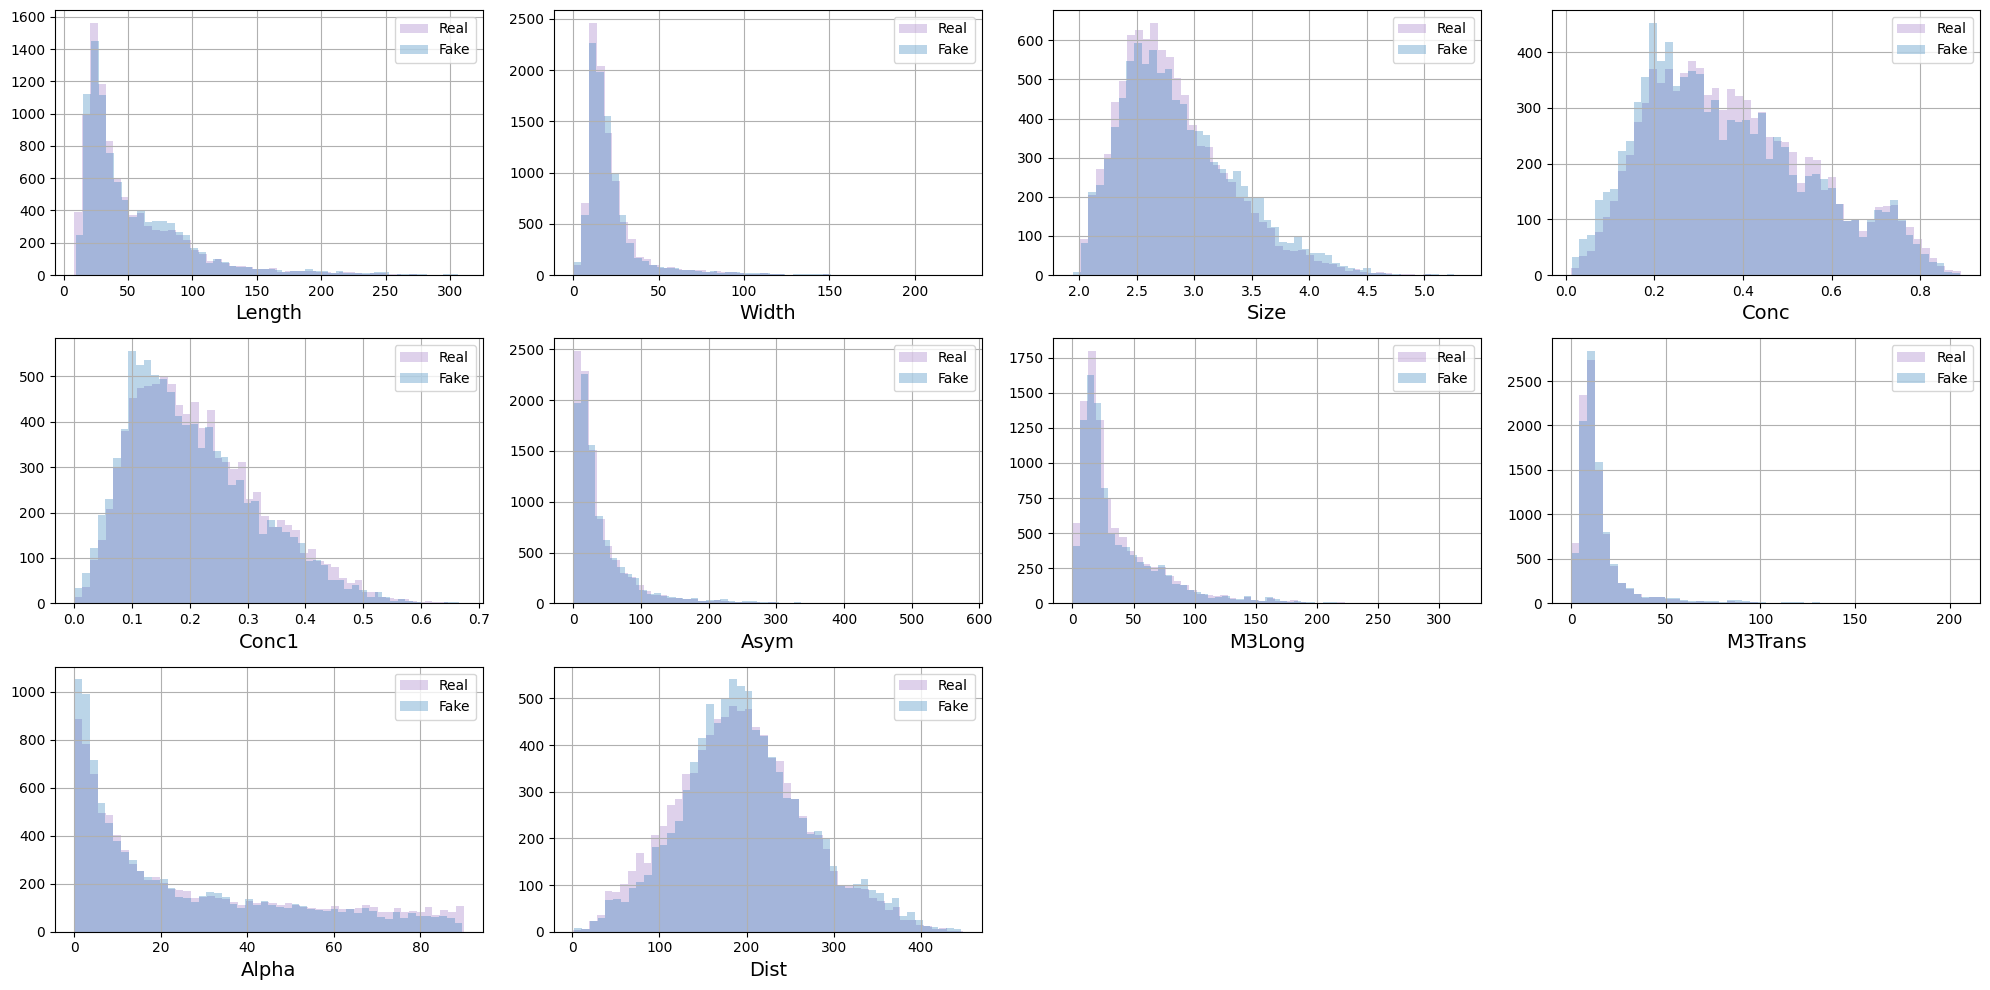

In [114]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

X_fake_train = qt.inverse_transform(X_fake_train)

# X_train = qt.inverse_transform(X_train)

plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

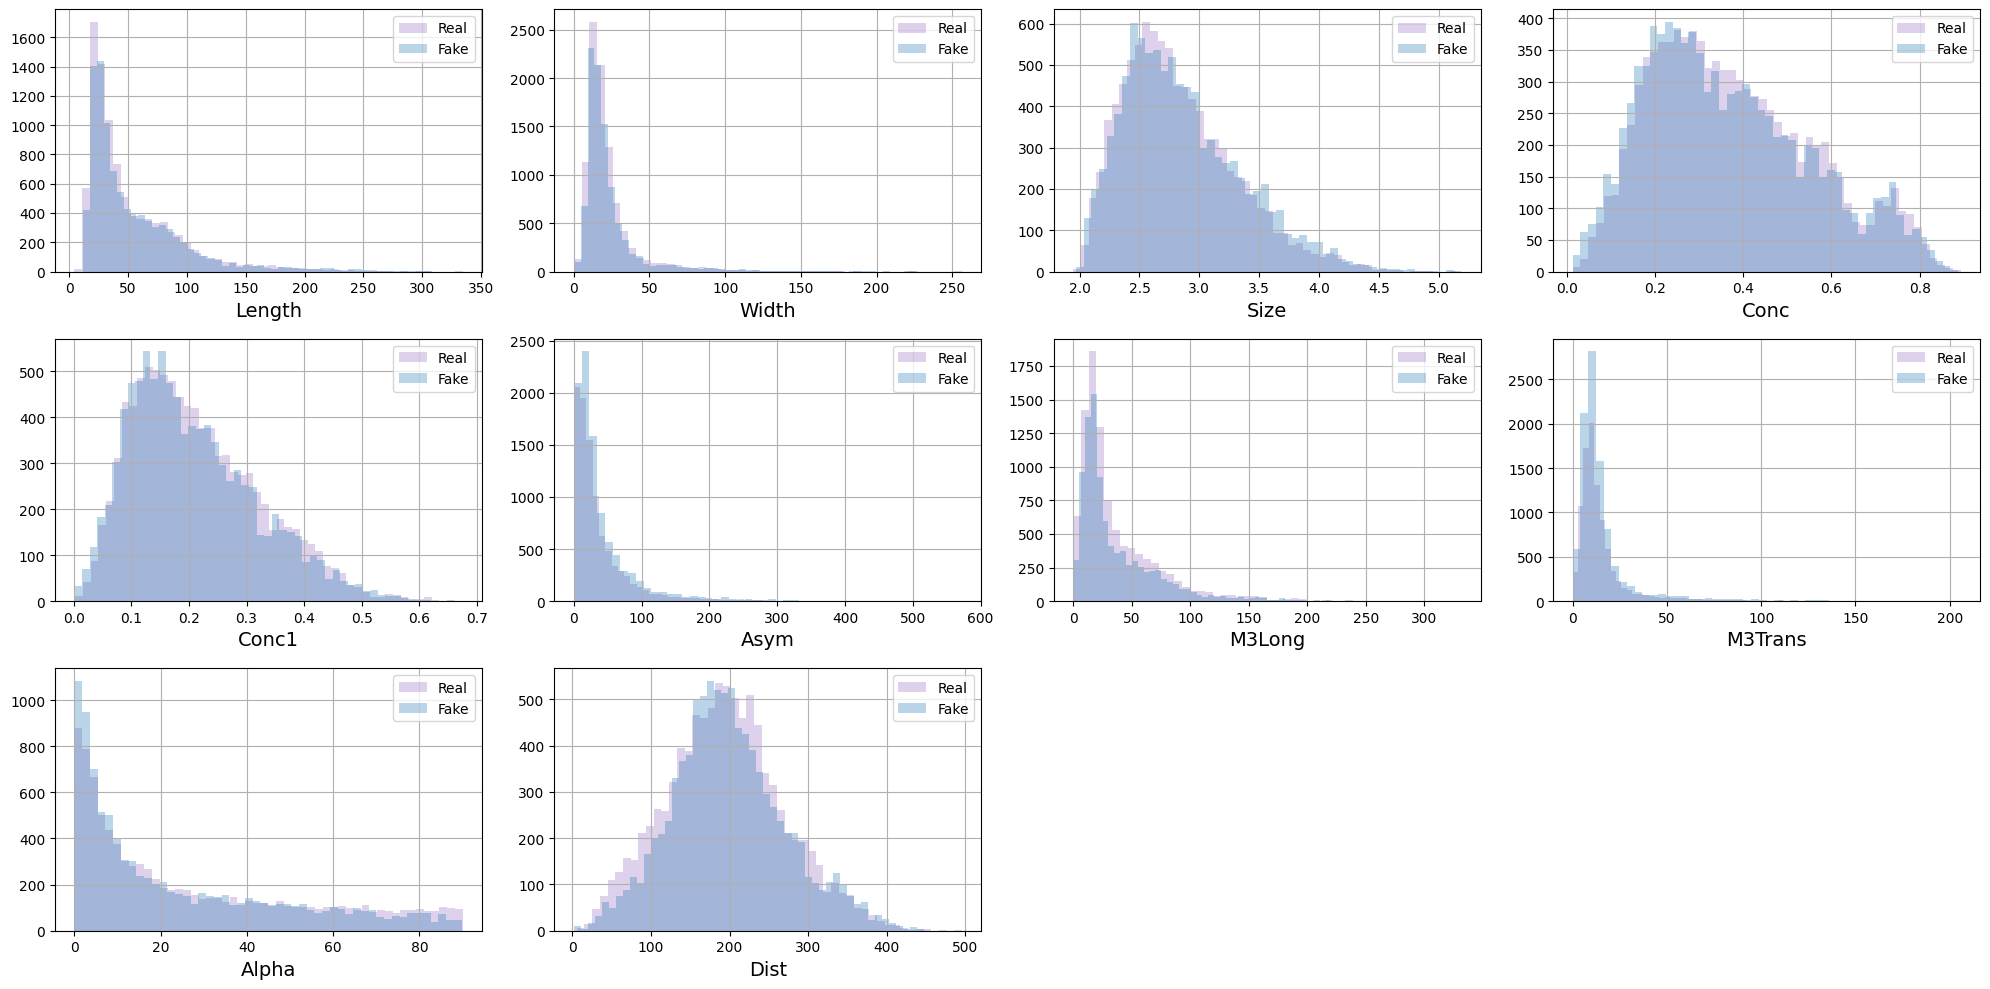

In [115]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

X_fake_test = qt.inverse_transform(X_fake_test)

# X_test = qt.inverse_transform(X_test)

plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Ответьте на вопросы:
- Похожи ли фейковые объекты на реальные?
- Точно ли хорошая идея сравнивать их на глаз?


Если посмотреть на распределения признаков, то можно однозначно сказать, что сгенерированные объекты похожи на реальные. При этом я не уверен, что сравнить их вот так на глаз хорошая идея. Скорее нам нужно смотреть на расстояния между объектами во всём признаковом пространстве, возможно применить какие-то методы кластеризации для большего понимания результатов модели.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [116]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [117]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [118]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6905962288851959


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Не очень понятно, что написать про эксперимент. Можно сказать, что GAN хорошая и достаточно простая модель. При этом при подборе гиперпараметров она наверняка покажет себя лучше.

В целом полученный результат нельзя назвать прям очень плохим, но и до идеального ему далеко. Конечно, хотелось бы получить ROC AUC = 0,5, чтобы наш дискриминатор только мог угадывать, сгенерированы ли данные или же они настоящие. При этом мы также можем сказать, что распределения признаков сгенерированных объектов очень похоже на распределение признаков настоящих объектов, а наша лосс функция ушла в 0, что тоже не может не радовать. В общем, можно сказать, что модель средненькая получилась.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Воспользуйтесь [DDPMScheduler](https://huggingface.co/docs/diffusers/api/schedulers/ddpm), возьмите 1000 шагов и подумайте, надо ли указать ещё какой-то параметр.

__Подсказка__: Посмотрите на распределения выше и почитайте описание шедулера в документации. Один из параметров - наследие от использования в генерации картинок, а у нас не картинки.

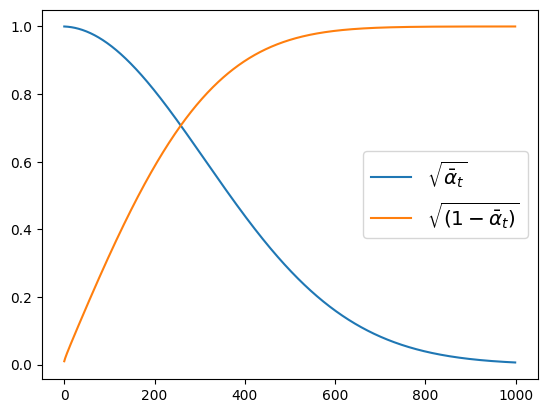

In [119]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качестве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [120]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.block = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )
        self.linear= nn.Linear(100, n_outputs)
        ### THE END OF YOUR CODE ###

    def forward(self, z, t, y):
        ### YOUR CODE IS HERE ######
        # Склейте z, t и y при помощи torch.cat
        # Подумайте по какому dim это нужно сделать (в качестве подсказки можете посмотреть документацию Linear)
        # А также о том, что t, скорее всего, одно число, а батч у вас будет большой!
        # Либо предусмотрите раздувание t где-то в другом месте
        # t = t.unsqueeze(0)
        # y = y.unsqueeze(0)

        t = t.view(-1, 1).to(DEVICE)
        y = y.view(-1, 1).to(DEVICE)

        temp = torch.cat((z.to(DEVICE), t, y), dim=1)
        temp = self.block(temp)
        temp = self.linear(temp)
        return temp

Думаю, качество модели можно будет измерить теми же методами, что ранее использовались для GAN'ов.

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [121]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    ### YOUR CODE IS HERE ######
    # Подсказки: вам понадобится .prev_sample после шага scheduler
    # А ещё цикл по таймстепам

    z = torch.rand(len(y), latent_dim, device = DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)

    for t in noise_scheduler.timesteps:
        t_tens = t.expand(z.shape[0], 1)
        with torch.no_grad():
            pred_noise = model(z, t_tens, y)
        z = scheduler.step(pred_noise, t, z).prev_sample

    X_fake = z.detach().cpu().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [122]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=True, clip_sample_range= 2.5)
        # self.scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                # Подсказки:
                # Подумайте какой шум вам тут нужен (uniform/normal?)
                # Помните про scheduler? Как вариант, можете генерировать случайный вектор из integer
                # И подавать его в add_noise и модель
                x = real_batch
                y = cond_batch
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                noise = torch.randn_like(x)
                timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(DEVICE)
                noisy_x = self.scheduler.add_noise(x, noise, timesteps)

                pred = self.model(noisy_x, timesteps, y)  # Note that we pass in the labels y

                loss = torch.nn.functional.mse_loss(pred, noise)

                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            idx_real = np.random.choice(len(X_real), 1000, replace=True)
            idx_noisy = np.random.choice(len(noisy_x), 1000, replace=True)
            other_agent_score(X_real[idx_real].cpu().detach().numpy(), y_cond[idx_real].cpu().detach().numpy(),
                              noisy_x[idx_noisy].cpu().detach().numpy(), y_cond[idx_noisy].cpu().detach().numpy())
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

Обучим модель на данных, указав количество входов.

У вас есть скрытое пространство и его размер, есть таймстепы и есть условие. Как легко догадаться, размер входа будет больше, чем просто размер скрытого пространства.

In [123]:
X_train_transformed = qt.fit_transform(X_train)
X_test_transformed = qt.transform(X_test)

In [124]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1]+1, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train_transformed, y_train)

Linear regression score: 0.68
Boosting score: 0.936
Linear regression score: 0.828
Boosting score: 0.934
Linear regression score: 0.866
Boosting score: 0.93
Linear regression score: 0.796
Boosting score: 0.9
Linear regression score: 0.836
Boosting score: 0.912
Linear regression score: 0.794
Boosting score: 0.934
Linear regression score: 0.894
Boosting score: 0.934
Linear regression score: 0.878
Boosting score: 0.928
Linear regression score: 0.908
Boosting score: 0.932
Linear regression score: 0.842
Boosting score: 0.924
Linear regression score: 0.734
Boosting score: 0.926
Linear regression score: 0.738
Boosting score: 0.922
Linear regression score: 0.782
Boosting score: 0.928
Linear regression score: 0.724
Boosting score: 0.924
Linear regression score: 0.878
Boosting score: 0.93
Linear regression score: 0.722
Boosting score: 0.946
Linear regression score: 0.866
Boosting score: 0.926
Linear regression score: 0.698
Boosting score: 0.92
Linear regression score: 0.78
Boosting score: 0.896


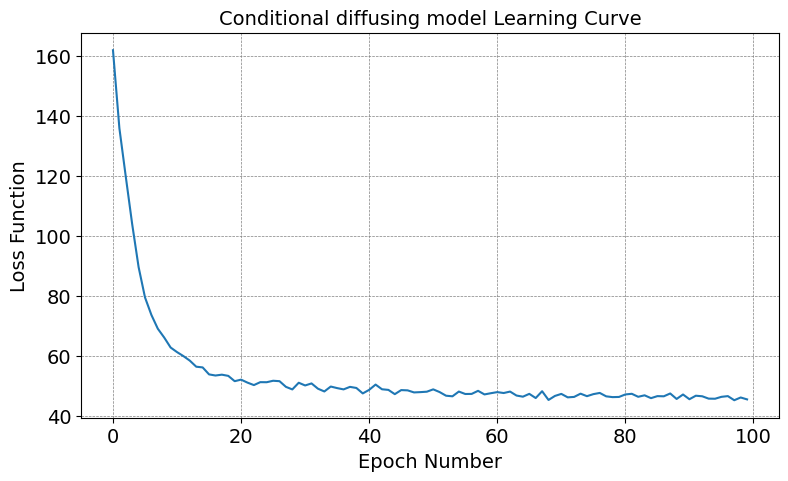

In [125]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

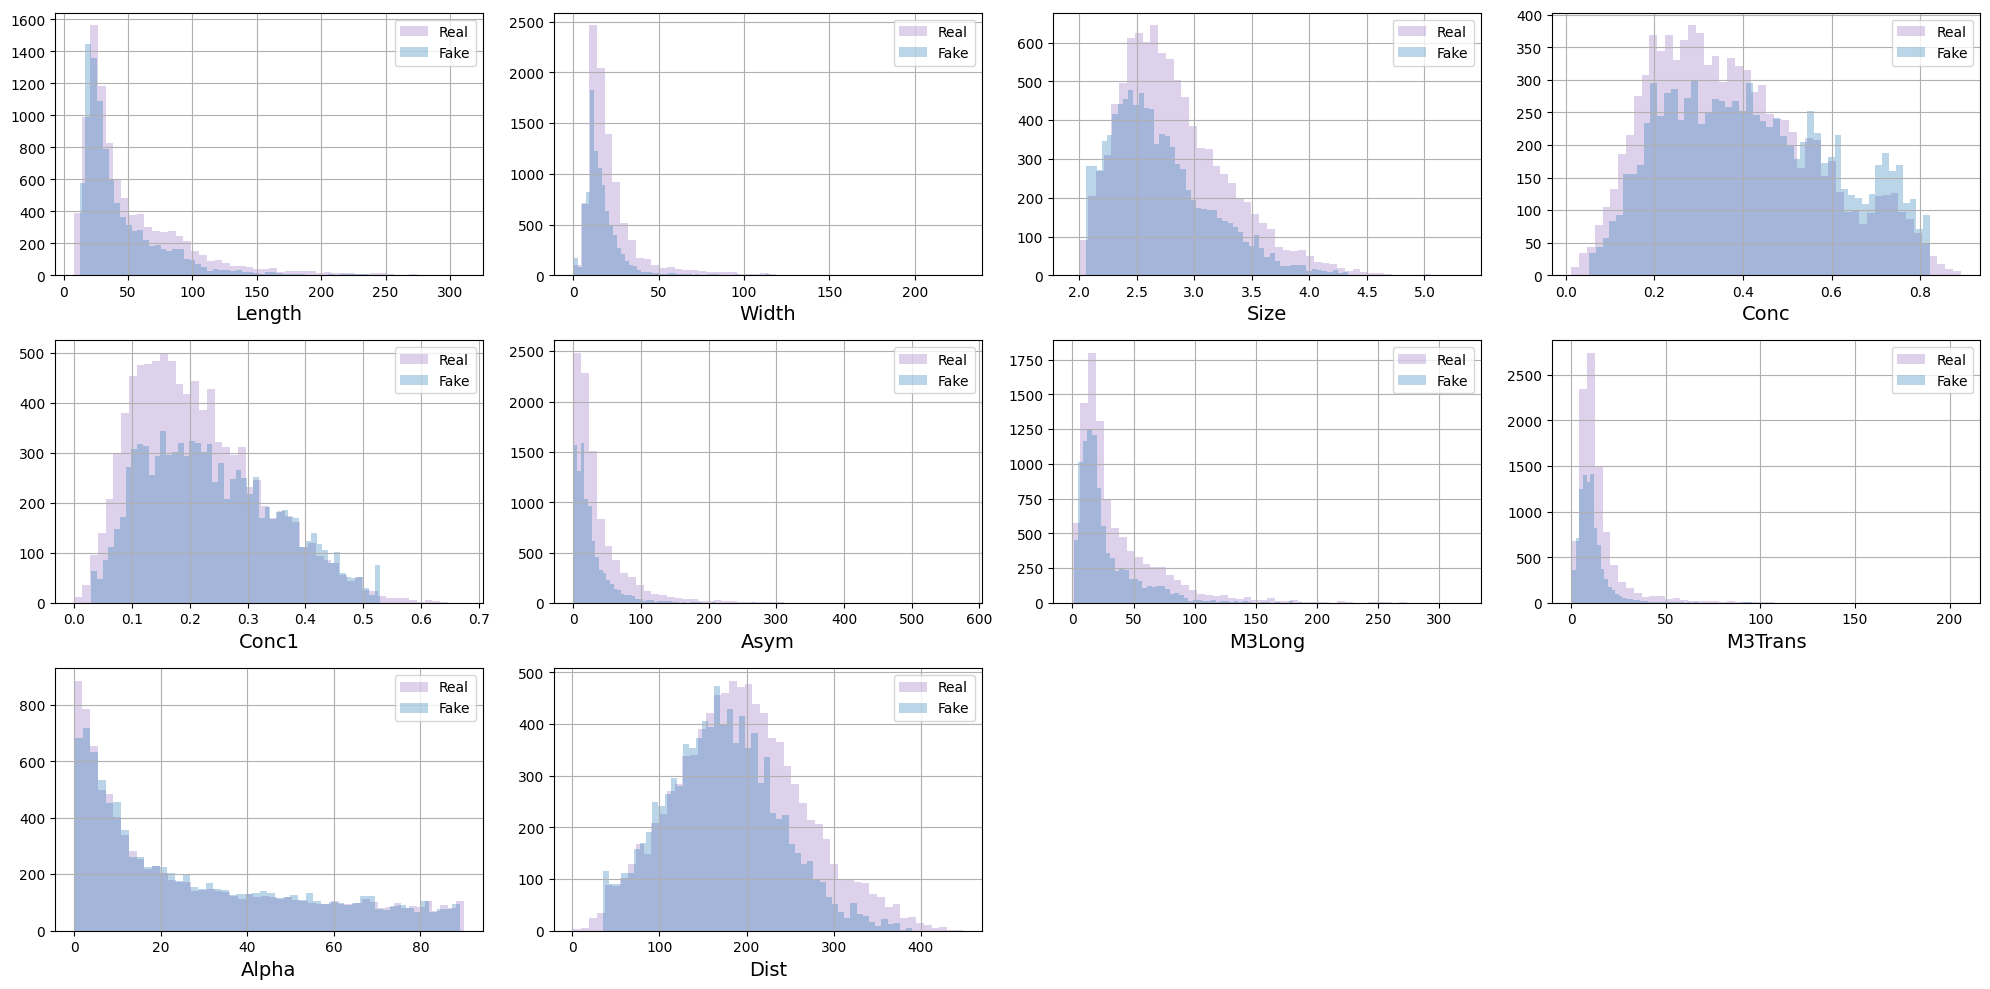

In [126]:
X_fake_train_diff = generate_with_diffusion(model, y_train, latent_dim, diffusionFitter.scheduler)

X_fake_train_diff = qt.inverse_transform(X_fake_train_diff)

# X_train = qt.inverse_transform(X_train)

plot_hists(X_train, X_fake_train_diff, names, label1="Real", label2="Fake", bins=50)

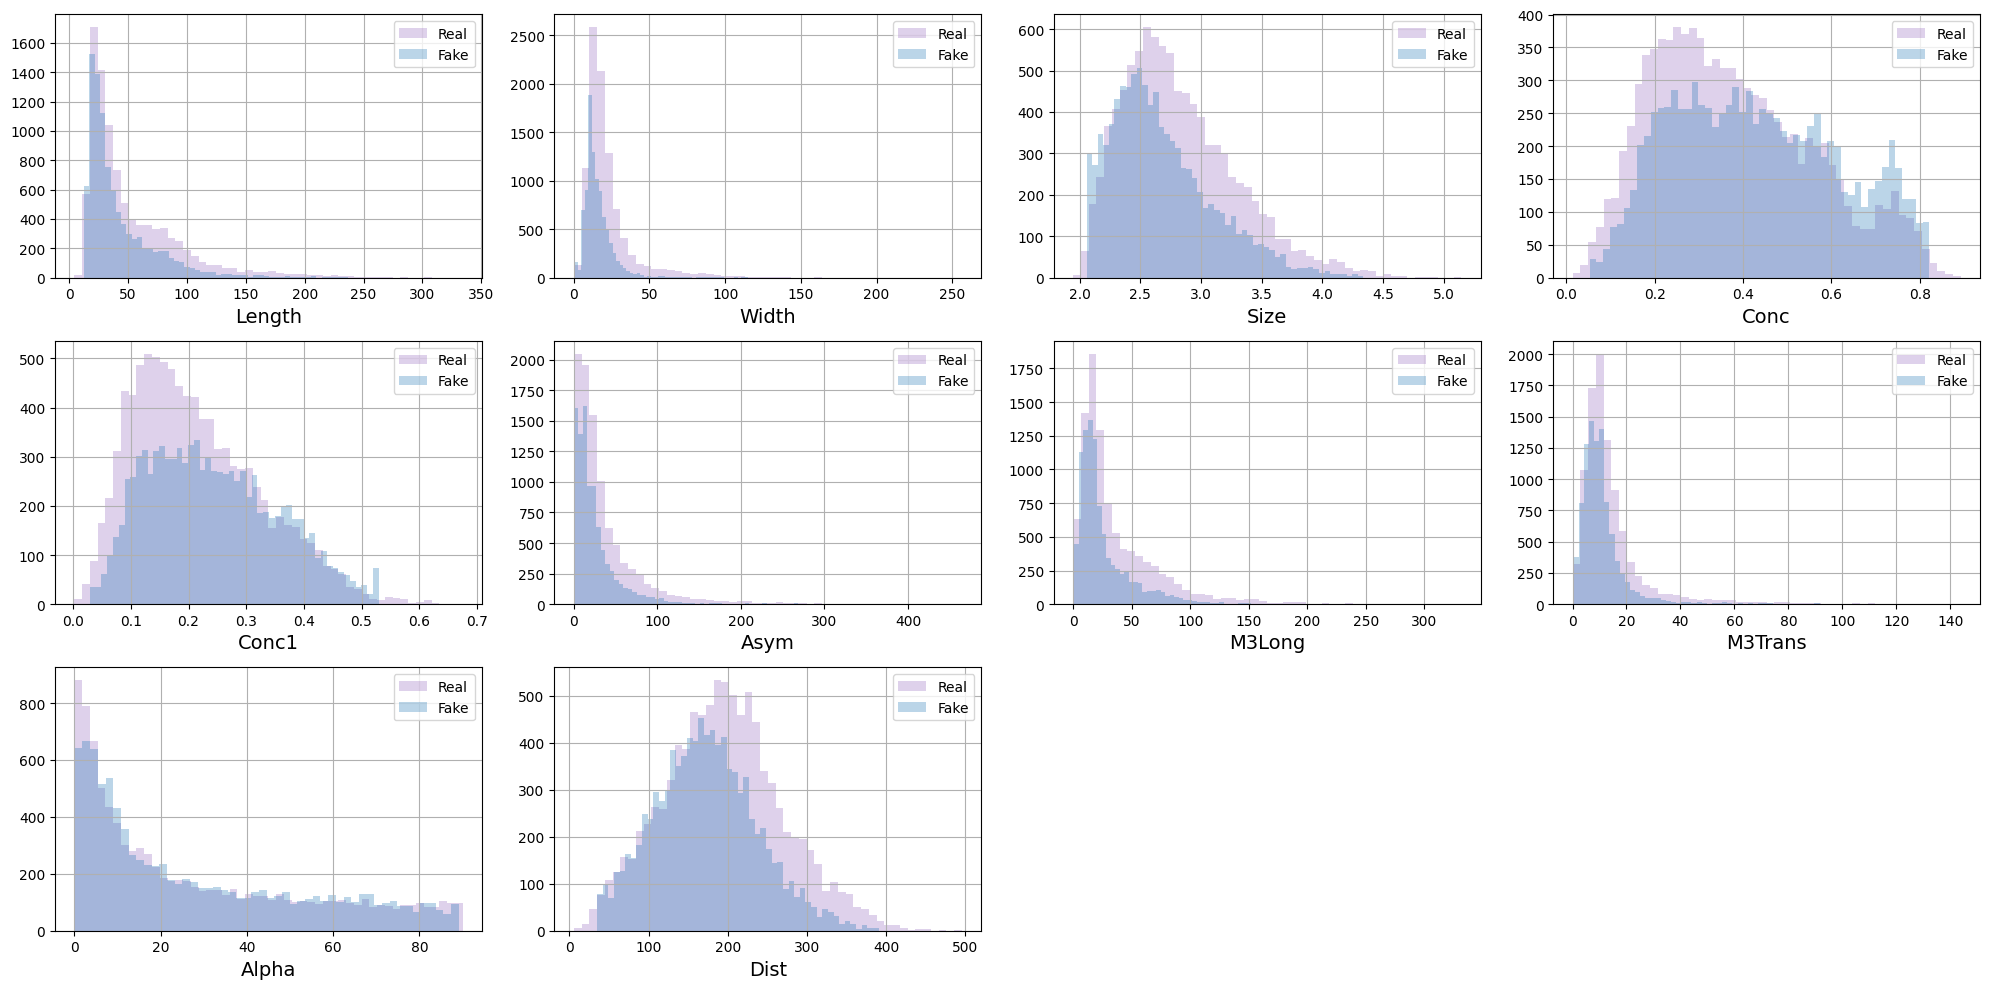

In [127]:
X_fake_test_diff = generate_with_diffusion(model, y_test, latent_dim, diffusionFitter.scheduler)

X_fake_test_diff = qt.inverse_transform(X_fake_test_diff)

# X_test = qt.inverse_transform(X_test)

plot_hists(X_test, X_fake_test_diff, names, label1="Real", label2="Fake", bins=50)

In [128]:
XX_train = np.concatenate((X_fake_train_diff, X_train), axis=0)
XX_test = np.concatenate((X_fake_test_diff, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train_diff) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test_diff) + [1] * len(X_test))

In [129]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [130]:
print(f'Accuracy score: {accuracy_score(yy_test, clf.predict(XX_test))}')

Accuracy score: 0.6773922187171398


In [131]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7452805448025821


Полученное значение ROC AUC получилось не очень высоким, но при этом оно далеко от значения 0.5. Accuracy тоже получилось сильно выше, чем 0.5. Это говорит о том, что наша модель плохо генерирует новые объекты, так как градиентный бустинг достаточно хорошо справляется с классификацией настоящих и сгенерированных объектов. При этом значение ROC AUC для диффузионной модели получилось больше, чем для GAN'ов, что говорит о том, что диффузионная модель хуже.

# Бонус (2 балла)

Кроме Diffusion и GAN вы изучили еще VAE и NF. В качестве бонуса релизуйте VAE, обучите, и в конце сравните качество теми же методами, что и в основной части ДЗ.

Разбалловка бонуса такая:
- Реализовать VAE - 1 балл
- Обучить VAE - 0.5 балла
- Провести сравнение с GAN и Diffusion аналогично 14 заданию основной части - 0.5 балла

Ниже приведены шаблоны. Они не особо щедры на комментарии, но поскольку задача бонусная, ожидаем, что вы в них разберетесь. Если они вам не нравятся - можете переписать как хотите.

Если же VAE вам кажется слишком скучным, то мы засчитаем реализацию NF, но шаблонов не предоставим. Бонус в таком случае тоже ограничен сверху 2 баллами и разбалловка не изменится.

In [132]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.mu = nn.Linear(64, lat_size)
        self.log_sigma = nn.Linear(64, lat_size)

        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma


class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()

        ### YOUR CODE IS HERE ######
        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

In [133]:
def generate_vae(decoder, y, latent_dim):
    ### YOUR CODE IS HERE ######
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    z = torch.randn((y.shape[0], latent_dim), dtype=torch.float, device=DEVICE)  # Создаём латентный вектор
    X_fake = decoder(z, y).cpu().detach().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

In [134]:
class VAEFitter(object):
    def __init__(
        self,
        encoder,
        decoder,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        KL_weight=0.001,
    ):

        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight

        self.criterion = nn.MSELoss()
        self.opt = torch.optim.RMSprop(
            list(self.encoder.parameters()) + list(self.decoder.parameters()),
            lr=self.lr,
        )

        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)

    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps

    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(
            -0.5 * torch.sum(1 + log_sigma - mu**2 - log_sigma.exp(), dim=1), dim=0
        )
        recon_loss = self.criterion(x, rec_x)
        return KL * self.KL_weight + recon_loss

    def compute_loss(self, x_batch, cond_batch):

        ### YOUR CODE IS HERE ######
        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z = self.sample_z(mu, log_sigma)
        x_rec = self.decoder(z, cond_batch)
        loss = self.custom_loss(x_batch, x_rec, mu, log_sigma)
        return loss
        ### THE END OF YOUR CODE ###

        return loss

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                # caiculate loss
                loss = self.compute_loss(x_batch, cond_batch)

                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()

            # caiculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

In [135]:
%%time
latent_dim = 10
encoder = Encoder(n_inputs=latent_dim + y.shape[1], lat_size=10)
decoder = Decoder(n_inputs = 11, n_outputs = X_train.shape[1])

vaeFitter = VAEFitter(
    encoder,
    decoder,
    batch_size=32,
    n_epochs=100,
    latent_dim=1,
    lr=0.0001,
    KL_weight=0.001,
)
vaeFitter.fit(X_train_transformed, y_train)

CPU times: user 1min 52s, sys: 1.8 s, total: 1min 54s
Wall time: 1min 55s


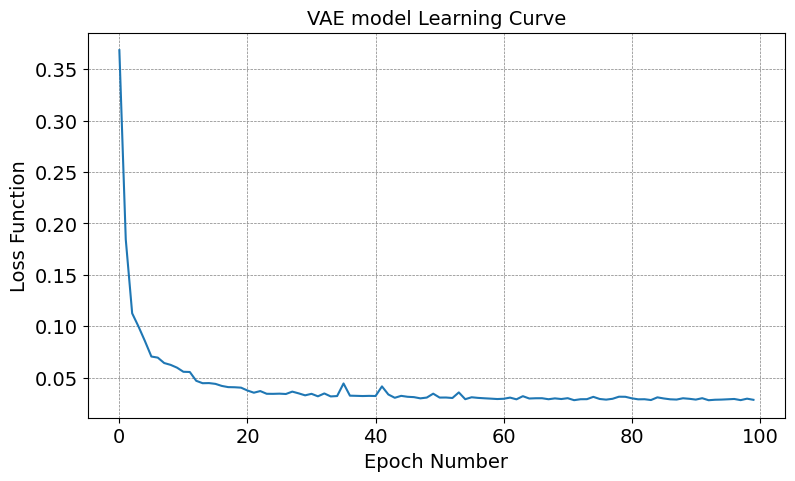

In [136]:
plt.figure(figsize=(9, 5))
plt.plot(vaeFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("VAE model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

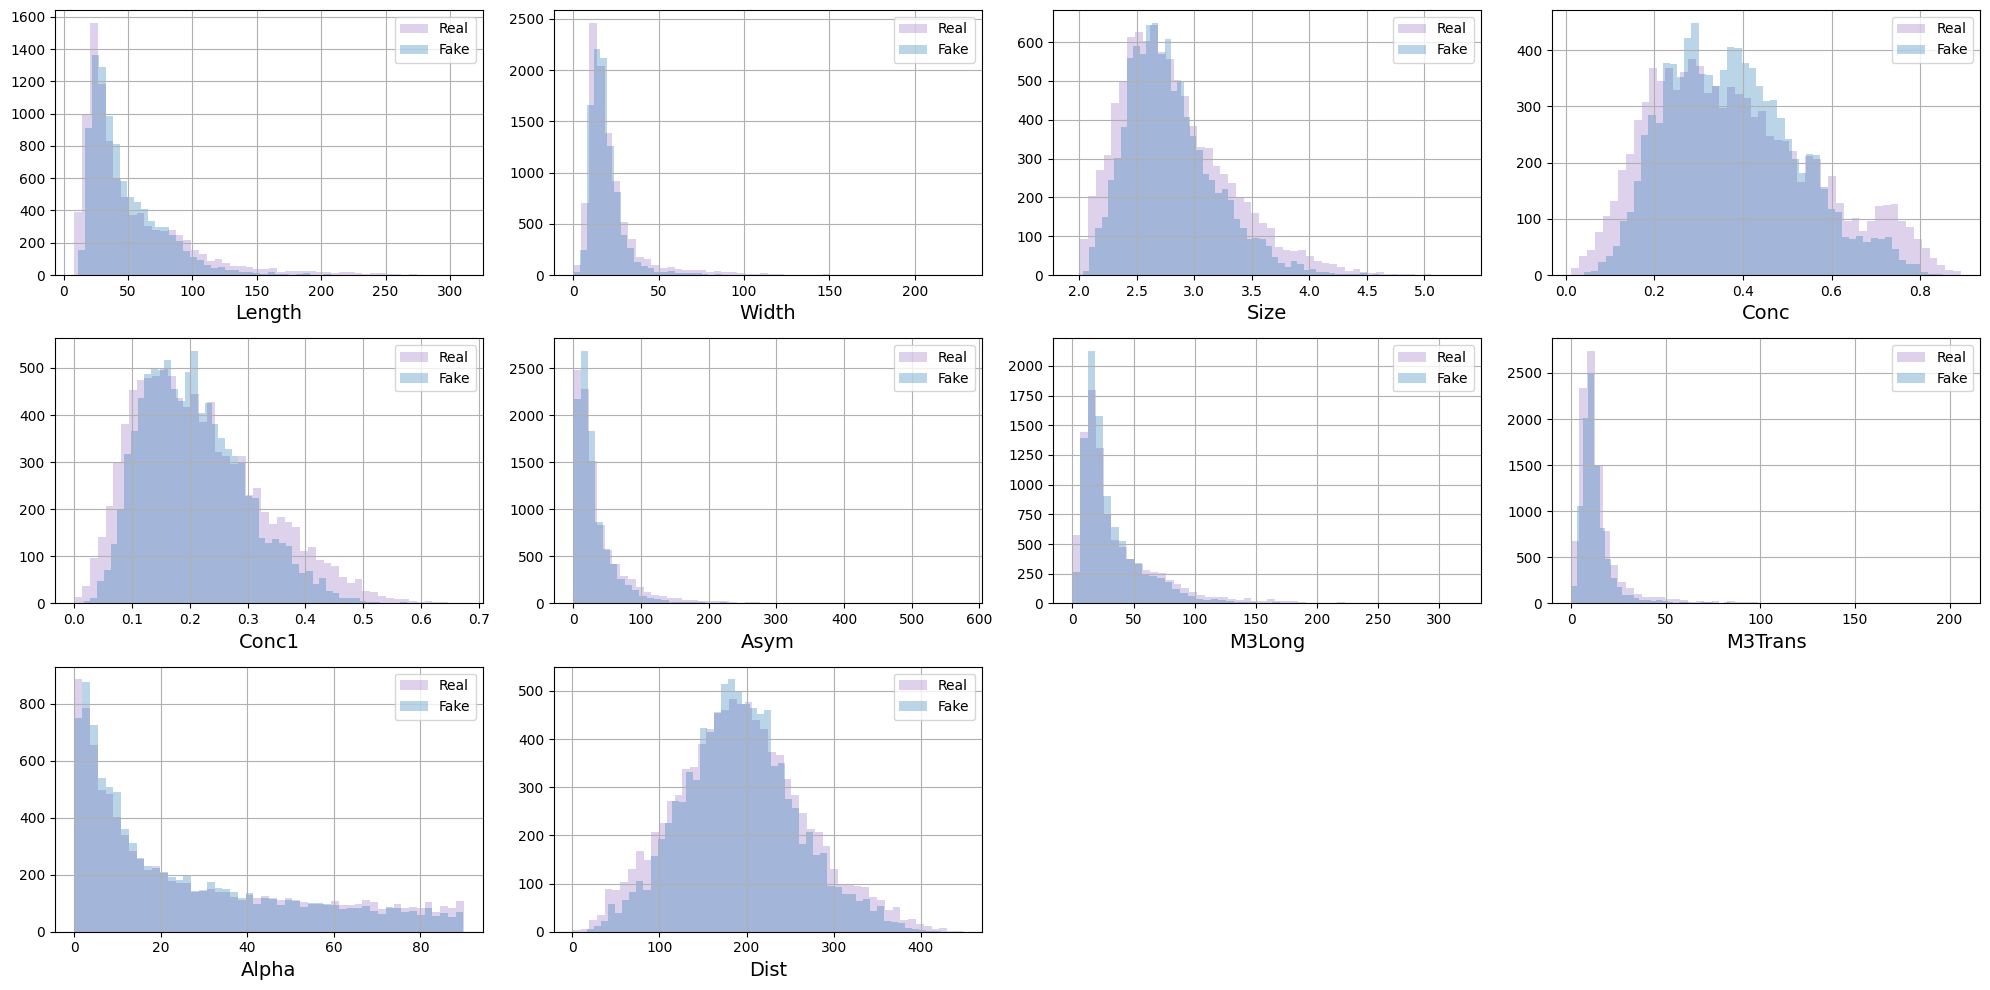

In [137]:
X_fake_train_vae = generate_vae(decoder, y_train, latent_dim)

X_fake_train_vae = qt.inverse_transform(X_fake_train_vae)

# X_train = qt.inverse_transform(X_train)

plot_hists(X_train, X_fake_train_vae, names, label1="Real", label2="Fake", bins=50)

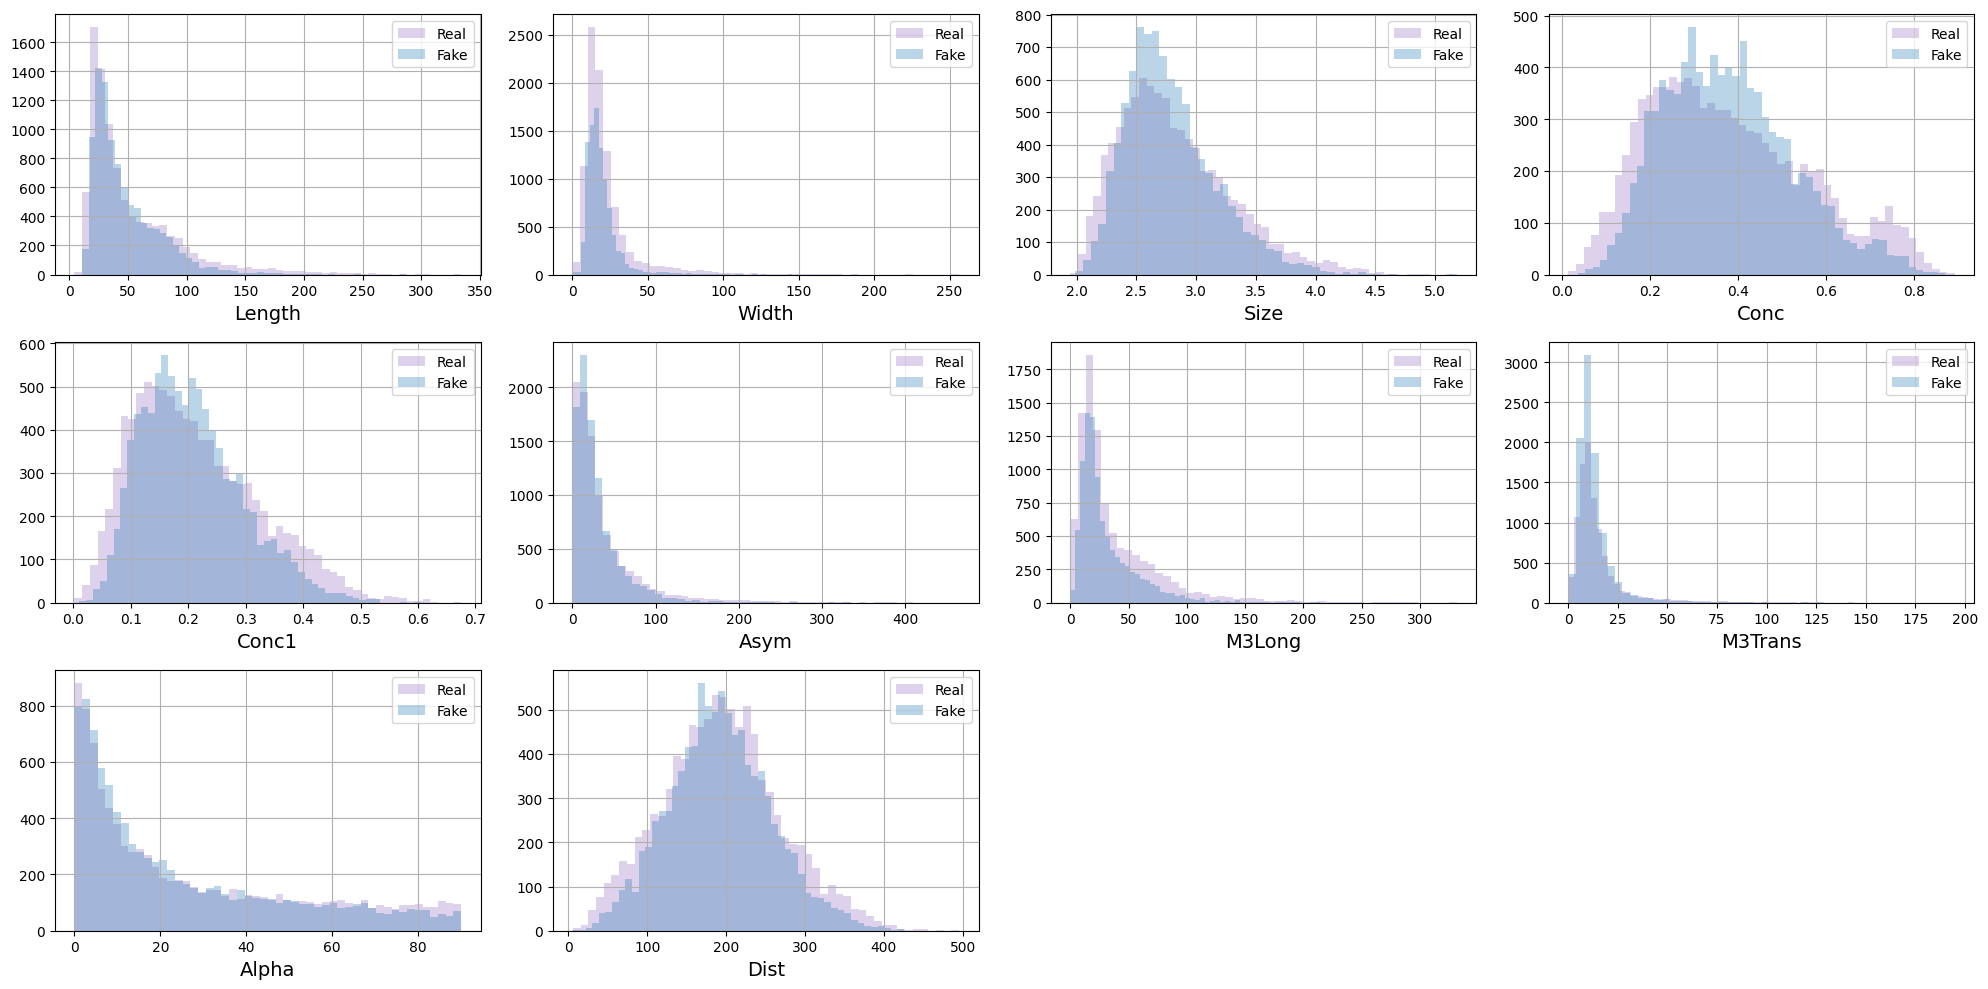

In [138]:
X_fake_test_vae = generate_vae(decoder, y_test, latent_dim)

X_fake_test_vae = qt.inverse_transform(X_fake_test_vae)

# X_train = qt.inverse_transform(X_train)

plot_hists(X_test, X_fake_test_vae, names, label1="Real", label2="Fake", bins=50)

In [139]:
XX_train = np.concatenate((X_fake_train_vae, X_train), axis=0)
XX_test = np.concatenate((X_fake_test_vae, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train_vae) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test_vae) + [1] * len(X_test))

In [140]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [141]:
print(f'Accuracy score: {accuracy_score(yy_test, clf.predict(XX_test))}')

Accuracy score: 0.6646161934805468


In [142]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7397197095093879


Получили ROC AUC чуть выше, чем в GAN'ax, но пониже, чем в диффузионной модели. Наверное, можно назвать данную модель сравнимой с диффузионной, но очень много зависит от подбора гиперпараметров, как мне кажется.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!